In [1]:
# !pip install -q statsforecast

In [2]:
#Read sales data with Pandas
import pandas as pd

sales = pd.read_csv('sales.csv')
sales.head()

,Date,Product_Category,Region,Units_Sold,Unit_Price,Revenue
0,2023-01-01,Electronics,North,23,24.04,552.92
1,2023-01-02,Electronics,North,15,87.96,1319.40
2,2023-01-03,Electronics,North,21,11.85,248.85
3,2023-01-04,Electronics,North,16,26.51,424.16
4,2023-01-05,Electronics,North,17,48.88,830.96


In [3]:
# Transform normal index with Datetime Index
sales['Date'] = pd.to_datetime(sales['Date'])
sales.set_index('Date', inplace=True)
sales.head()

,Product_Category,Region,Units_Sold,Unit_Price,Revenue
Date,,,,,
2023-01-01,Electronics,North,23,24.04,552.92
2023-01-02,Electronics,North,15,87.96,1319.40
2023-01-03,Electronics,North,21,11.85,248.85
2023-01-04,Electronics,North,16,26.51,424.16
2023-01-05,Electronics,North,17,48.88,830.96


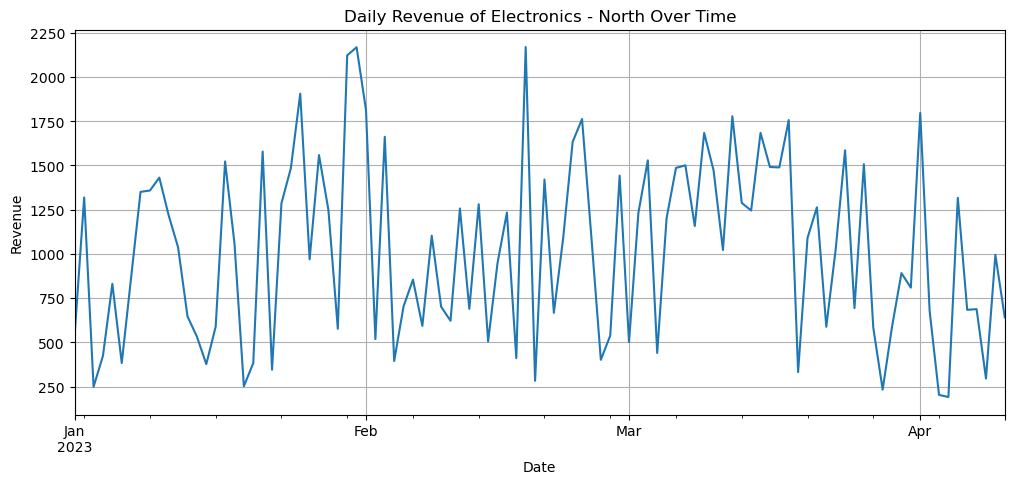

In [4]:
# Time Series Line Plot
import matplotlib.pyplot as plt

# Focus on a single product and region for clarity
filtered_sales = sales[(sales["Product_Category"] == "Electronics") & (sales["Region"] == "North")]
filtered_sales.index = sales[(sales["Product_Category"] == "Electronics") & (sales["Region"] == "North")].index
filtered_sales['Revenue'].plot(figsize=(12, 5), title='Daily Revenue of Electronics - North Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [5]:
#Creating Lag Features from Revenue
sales_lag = sales.copy()
sales_lag['Revenue_lag_1'] = sales_lag['Revenue'].shift(1)
sales_lag['Revenue_lag_3'] = sales_lag['Revenue'].shift(3)

sales_lag.head()

,Product_Category,Region,Units_Sold,Unit_Price,Revenue,Revenue_lag_1,Revenue_lag_3
Date,,,,,,,
2023-01-01,Electronics,North,23,24.04,552.92,NaN,NaN
2023-01-02,Electronics,North,15,87.96,1319.40,552.92,NaN
2023-01-03,Electronics,North,21,11.85,248.85,1319.40,NaN
2023-01-04,Electronics,North,16,26.51,424.16,248.85,552.92
2023-01-05,Electronics,North,17,48.88,830.96,424.16,1319.40


In [6]:
#Calculating Autocorrelation for Lag one

sales['Revenue'].autocorr(lag=1)

-0.03351573596646339

In [7]:
# Datetime Resampling
sales[['Units_Sold', 'Unit_Price', 'Revenue']].resample('ME').sum()

,Units_Sold,Unit_Price,Revenue
Date,,,
2023-01-31,7544,20328.18,415385.92
2023-02-28,6651,18165.35,358200.51
2023-03-31,7332,19651.29,384951.30
2023-04-30,2501,5796.65,121074.56


In [8]:
# Datetime slicing
sales = sales.sort_index()
sales['2023-01-01':'2023-01-07']

,Product_Category,Region,Units_Sold,Unit_Price,Revenue
Date,,,,,
2023-01-01,Electronics,North,23,24.04,552.92
2023-01-01,Clothing,South,21,28.53,599.13
2023-01-01,Clothing,West,13,23.50,305.50
2023-01-01,Electronics,West,14,94.45,1322.30
2023-01-01,Home & Kitchen,North,14,26.58,372.12
...,...,...,...,...,...
2023-01-07,Clothing,South,19,54.00,1026.00
2023-01-07,Books,West,20,48.82,976.40
2023-01-07,Electronics,South,25,83.30,2082.50


In [9]:
# Missing Data forward filling

sales_filled = sales.ffill()

In [10]:
# Missing Data backward filling

sales_filled = sales.bfill()

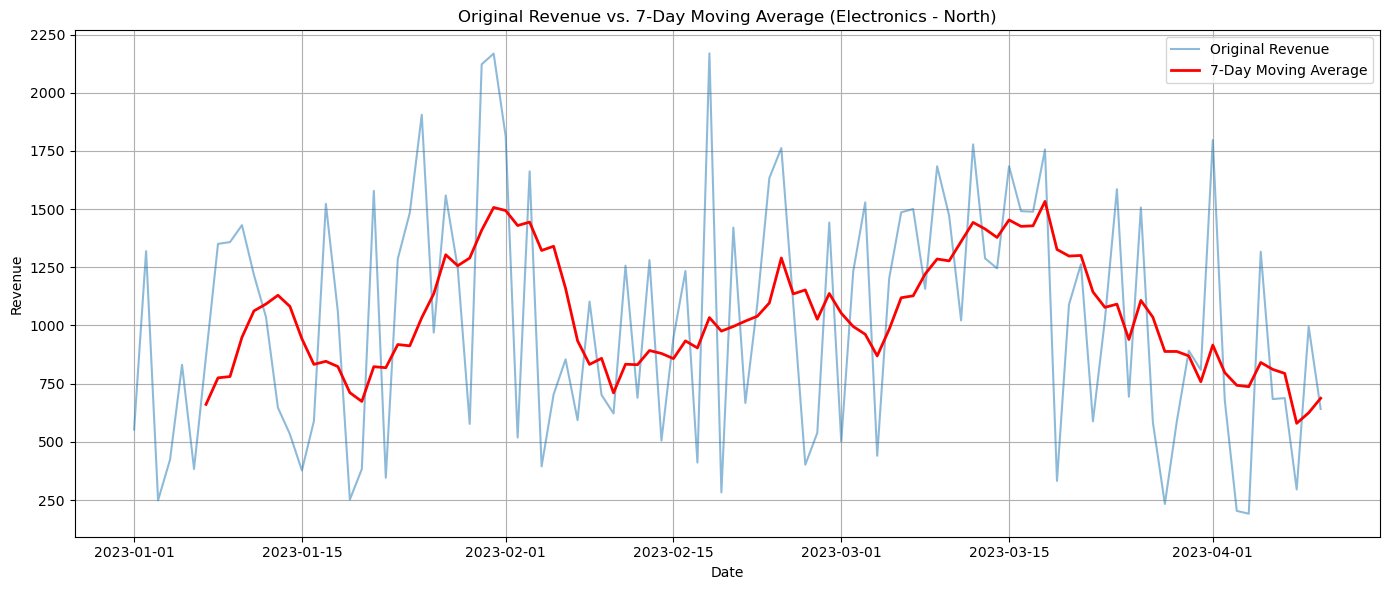

In [11]:
#Revenue Sales Moving Average for 7 days
import matplotlib.pyplot as plt

# Calculate 7-day moving average
filtered_sales["7_day_SMA"] = filtered_sales["Revenue"].rolling(window=7).mean()

# Plot the original vs moving average
plt.figure(figsize=(14, 6))
plt.plot(filtered_sales.index, filtered_sales["Revenue"], label="Original Revenue", alpha=0.5)
plt.plot(filtered_sales.index, filtered_sales["7_day_SMA"], label="7-Day Moving Average", color="red", linewidth=2)

plt.title("Original Revenue vs. 7-Day Moving Average (Electronics - North)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Centered Moving Average

filtered_sales["7_day_CMA"] = filtered_sales["Revenue"].rolling(window=7, center=True).mean()

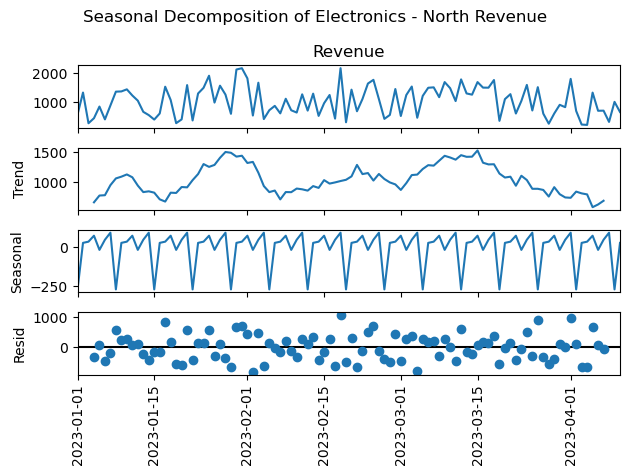

,Observed,Trend,Seasonality,Noise
Date,,,,
2023-01-01,552.92,NaN,-270.392308,NaN
2023-01-02,1319.40,NaN,29.320330,NaN
2023-01-03,248.85,NaN,37.141209,NaN
2023-01-04,424.16,661.070000,75.443391,-312.353391
2023-01-05,830.96,775.041429,-15.780181,71.698752


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition (choose model: 'additive' or 'multiplicative')
decomposition = seasonal_decompose(filtered_sales['Revenue'], model='additive', period=7)

# Create DataFrame with all components
decomposed_df = pd.DataFrame({
    "Observed": decomposition.observed,
    "Trend": decomposition.trend,
    "Seasonality": decomposition.seasonal,
    "Noise": decomposition.resid
})

# Plot the decomposed components
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Electronics - North Revenue", fontsize=12)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

decomposed_df.head()

In [14]:
# Weighted Moving Average
import numpy as np

weights = np.arange(1, 8)  #
filtered_sales['WMA_7_Revenue'] = filtered_sales['Revenue'].rolling(window=7).apply(
    lambda x: np.dot(x, weights)/weights.sum(), raw=True
)

In [15]:
# Simple Exponential Smoothing

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(filtered_sales['Revenue']).fit(smoothing_level=0.3, optimized=False)
filtered_sales['SES_Revenue'] = model.fittedvalues

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [16]:
# ADF Test to detect stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(filtered_sales['Revenue'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Reject H₀: Time series is likely stationary.")
else:
    print("Fail to reject H₀: Time series is likely non-stationary.")

ADF Statistic: -9.158458360965549
p-value: 2.5714338496418896e-15
Reject H₀: Time series is likely stationary.


In [17]:
# KPSS Test to detect stationarity

from statsmodels.tsa.stattools import kpss

result = kpss(filtered_sales['Revenue'], regression='c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Reject H₀: Time series is likely non-stationary.")
else:
    print("Fail to reject H₀: Time series is likely stationary.")


KPSS Statistic: 0.1569886928104136
p-value: 0.1
Fail to reject H₀: Time series is likely stationary.


C:\Users\corne\AppData\Local\Temp\ipykernel_28348\4114276940.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(filtered_sales['Revenue'], regression='c')


In [18]:
#First Order Differencing

filtered_sales['First_Diff'] = filtered_sales['Revenue'].diff()
filtered_sales.head()

,Product_Category,Region,Units_Sold,Unit_Price,Revenue,7_day_SMA,7_day_CMA,WMA_7_Revenue,SES_Revenue,First_Diff
Date,,,,,,,,,,
2023-01-01,Electronics,North,23,24.04,552.92,NaN,NaN,NaN,552.92000,NaN
2023-01-02,Electronics,North,15,87.96,1319.40,NaN,NaN,NaN,552.92000,766.48
2023-01-03,Electronics,North,21,11.85,248.85,NaN,NaN,NaN,782.86400,-1070.55
2023-01-04,Electronics,North,16,26.51,424.16,NaN,661.070000,NaN,622.65980,175.31
2023-01-05,Electronics,North,17,48.88,830.96,NaN,775.041429,NaN,563.10986,406.80


In [19]:
#Weekly Seasonal Differencing

filtered_sales['Seasonal_Weekly_Diff'] = filtered_sales['Revenue'].diff(7)
filtered_sales

,Product_Category,Region,Units_Sold,Unit_Price,Revenue,7_day_SMA,7_day_CMA,WMA_7_Revenue,SES_Revenue,First_Diff,Seasonal_Weekly_Diff
Date,,,,,,,,,,,
2023-01-01,Electronics,North,23,24.04,552.92,NaN,NaN,NaN,552.920000,NaN,NaN
2023-01-02,Electronics,North,15,87.96,1319.40,NaN,NaN,NaN,552.920000,766.48,NaN
2023-01-03,Electronics,North,21,11.85,248.85,NaN,NaN,NaN,782.864000,-1070.55,NaN
2023-01-04,Electronics,North,16,26.51,424.16,NaN,661.070000,NaN,622.659800,175.31,NaN
2023-01-05,Electronics,North,17,48.88,830.96,NaN,775.041429,NaN,563.109860,406.80,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,Electronics,North,13,52.61,683.93,811.440000,624.925714,746.345714,795.630846,-633.07,-207.52
2023-04-07,Electronics,North,15,45.87,688.05,794.108571,687.462857,715.498214,762.120592,4.12,-121.32
2023-04-08,Electronics,North,21,14.08,295.68,579.677143,NaN,590.891071,739.899414,-392.37,-1501.02


In [20]:
forecast = model.forecast(steps=5)
forecast

2023-04-11    698.556859
2023-04-12    698.556859
2023-04-13    698.556859
2023-04-14    698.556859
2023-04-15    698.556859
Freq: D, dtype: float64

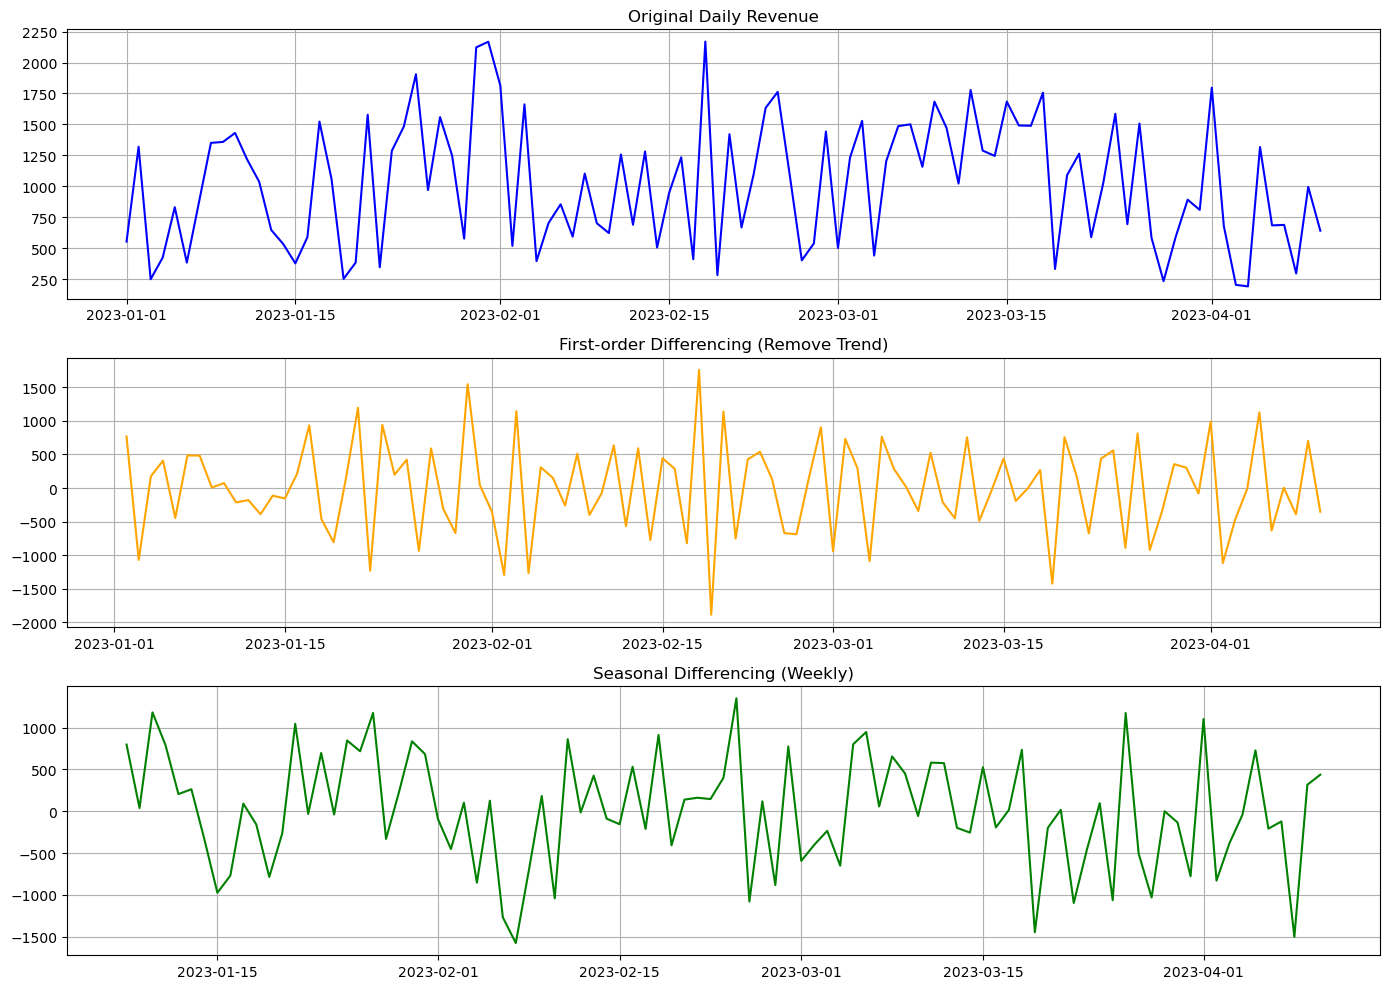

In [21]:
daily_revenue = filtered_sales["Revenue"]

# Compute first-order and seasonal differencing
diff_1 = daily_revenue.diff()
diff_seasonal = daily_revenue.diff(7)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    "Original": daily_revenue,
    "First_Diff": diff_1,
    "Seasonal_Diff": diff_seasonal
})

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(comparison_df["Original"], label='Original', color='blue')
plt.title("Original Daily Revenue")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(comparison_df["First_Diff"], label='First-order Differencing', color='orange')
plt.title("First-order Differencing (Remove Trend)")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(comparison_df["Seasonal_Diff"], label='Seasonal Differencing (lag=7)', color='green')
plt.title("Seasonal Differencing (Weekly)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Fitting Autoregressive Model

from statsmodels.tsa.ar_model import AutoReg
p = 1
model = AutoReg(filtered_sales["Revenue"], lags=p, trend="c") 
res = model.fit()

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


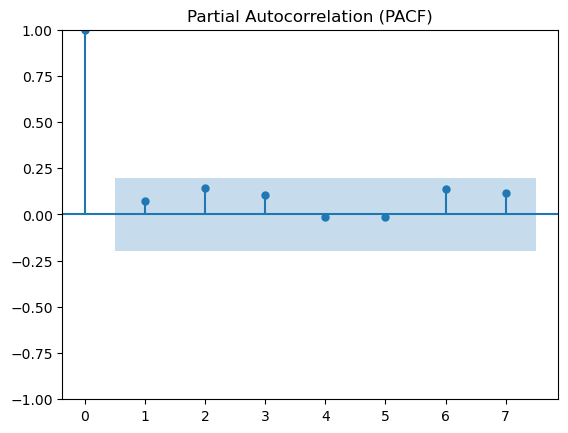

In [23]:
#PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(filtered_sales["Revenue"], lags=7)
plt.title('Partial Autocorrelation (PACF)')
plt.show()

In [24]:
# Fitting Moving Average Model
from statsmodels.tsa.arima.model import ARIMA 

q = 1
model = ARIMA(filtered_sales["Revenue"], order=(0,0,q)) 
res = model.fit()

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


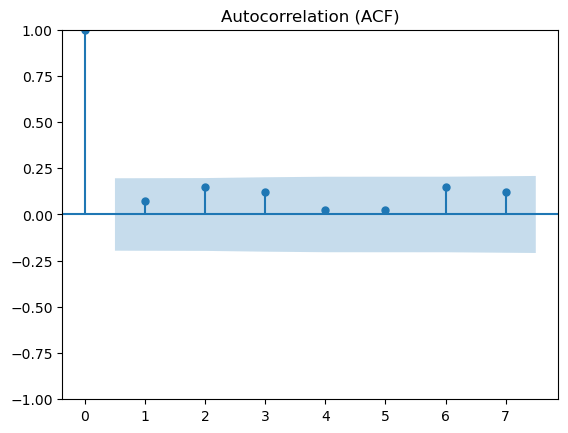

In [25]:
#ACF Plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(filtered_sales["Revenue"], lags=7)
plt.title('Autocorrelation (ACF)')
plt.show()

In [26]:
#Fitting ARMA model
from statsmodels.tsa.arima.model import ARIMA 

model = ARIMA(filtered_sales["Revenue"], order=(p, 0, q))
result = model.fit()

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [27]:
#Fitting ARIMA model

from statsmodels.tsa.arima.model import ARIMA 
d = 1

model = ARIMA(filtered_sales["Revenue"], order=(p,d,q)) 
res = model.fit()

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
# Fitting SARIMA model

from statsmodels.tsa.statespace.sarimax import SARIMAX

s = 7 #weekly seasonality
p, d, q = 1, 1, 1      #non-seasonal orders
P, D, Q = 1, 1, 1     #seasonal orders

model = SARIMAX(filtered_sales["Revenue"],
                 order=(p, d, q),
                 seasonal_order=(P, D, Q, s),
                 trend="c")
res = model.fit()

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
# Fitting Holt Linear Method

from statsmodels.tsa.holtwinters import ExponentialSmoothing

alpha = 0.4   # smoothing for level
beta = 0.2    # smoothing for trend

model = ExponentialSmoothing(filtered_sales["Revenue"], trend='add', seasonal=None)
res = model.fit(
    smoothing_level=alpha,
    smoothing_trend=beta,
    optimized=False)

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [30]:
# Fitting Holt-Winters Additive Model

from statsmodels.tsa.holtwinters import ExponentialSmoothing

alpha = 0.4   # level smoothing
beta = 0.2    # trend smoothing
gamma = 0.3   # seasonal smoothing
seasonal_period = 7  # seasonality trend

model = ExponentialSmoothing(
    filtered_sales["Revenue"],
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_period)

res = model.fit(
    smoothing_level=alpha,
    smoothing_slope=beta,
    smoothing_seasonal=gamma,
    optimized=False)

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\AppData\Local\Temp\ipykernel_28348\2922172004.py:16: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  res = model.fit(


In [31]:
# Fit ARIMAX and SARIMAX model

from statsmodels.tsa.statespace.sarimax import SARIMAX

y = filtered_sales['Revenue']
X = filtered_sales[['Units_Sold', 'Unit_Price']]  # multivariable input

# ARIMAX model
arimax_model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
arimax_results = arimax_model.fit()

#SARIMAX model

sarimax_model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
arimax_results = sarimax_model.fit()

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


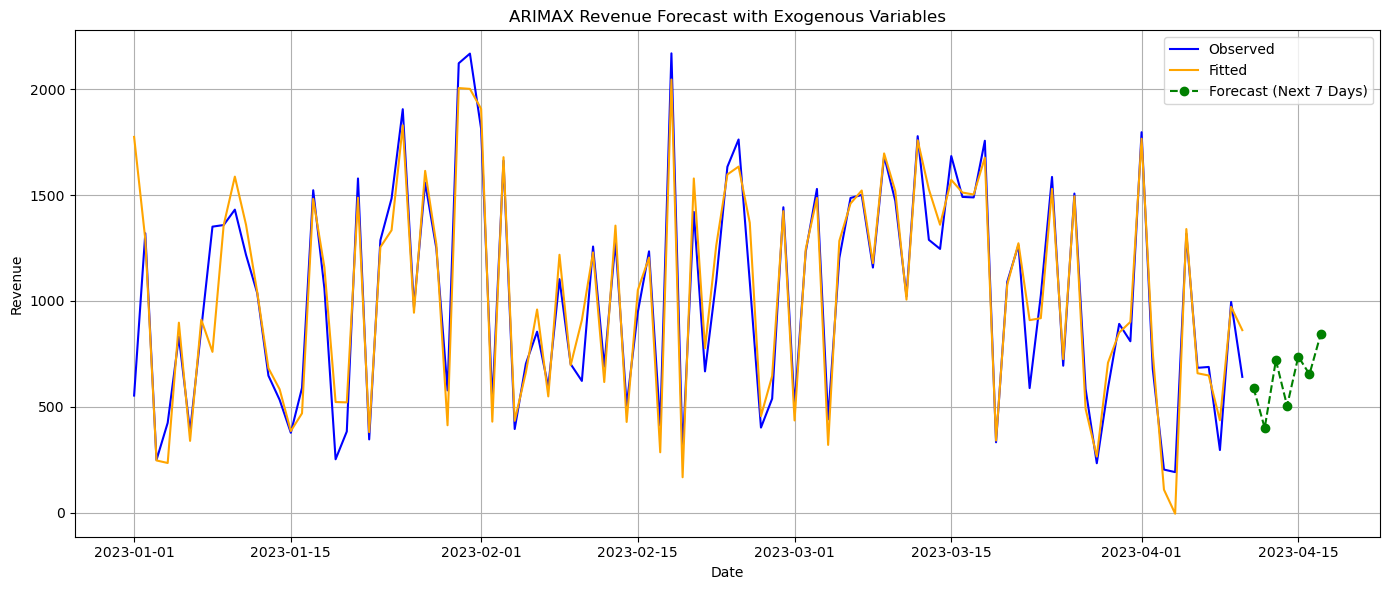

In [32]:
# Point Forecast with ARIMAX model 
last_date = filtered_sales.index.max()

# Create future exogenous DataFrame
X_future = pd.DataFrame({
    'Units_Sold': [20, 18, 21, 19, 22, 20, 23],
    'Unit_Price': [30.0, 28.5, 32.0, 27.0, 29.0, 31.0, 34.0]
}, index=pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7))

# Forecast using ARIMAX
arimax_forecast = arimax_results.forecast(steps=7, exog=X_future)

# Plot original data and forecast 
plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Observed', color='blue')
plt.plot(y.index, arimax_results.fittedvalues, label='Fitted', color='orange')
plt.plot(arimax_forecast.index, arimax_forecast, label='Forecast (Next 7 Days)', 
         color='green', linestyle='--', marker='o')

plt.title('ARIMAX Revenue Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# ARIMAX Forecast

arimax_forecast

2023-04-11    589.653009
2023-04-12    399.837927
2023-04-13    719.790064
2023-04-14    504.073995
2023-04-15    737.011361
2023-04-16    653.729940
2023-04-17    841.985925
Freq: D, Name: predicted_mean, dtype: float64

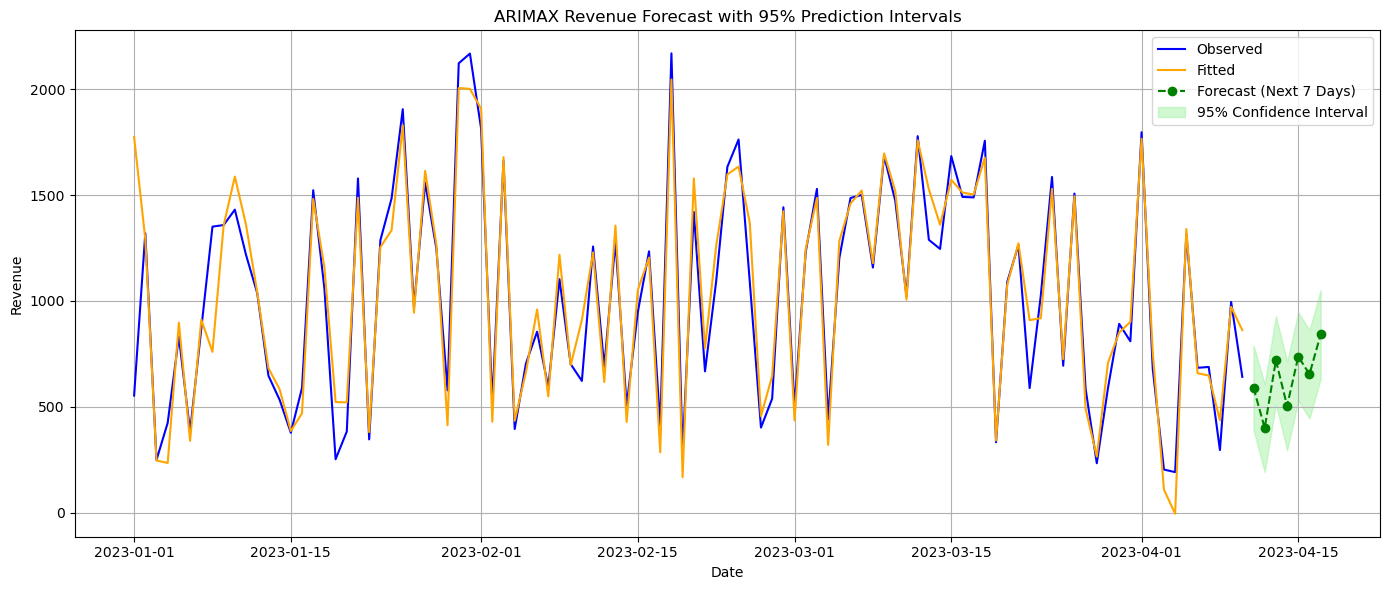

In [34]:
#ARIMAX Interval Forecast

# Get forecast with confidence intervals
forecast_obj = arimax_results.get_forecast(steps=7, exog=X_future)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

plt.figure(figsize=(14, 6))

plt.plot(filtered_sales.index, filtered_sales['Revenue'], label='Observed', color='blue')
plt.plot(filtered_sales.index, arimax_results.fittedvalues, label='Fitted', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (Next 7 Days)', color='green', linestyle='--', marker='o')

plt.fill_between(forecast_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.4, label='95% Confidence Interval')

plt.title('ARIMAX Revenue Forecast with 95% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
conf_int

,lower Revenue,upper Revenue
2023-04-11,390.014224,789.291794
2023-04-12,191.874941,607.800913
2023-04-13,510.955785,928.624342
2023-04-14,295.100725,713.047265
2023-04-15,527.997725,946.024997
2023-04-16,444.675145,862.784734
2023-04-17,632.929015,1051.042835


In [36]:
n_test = 7

# Split data
y_train = y[:-n_test]
y_test = y[-n_test:]
X_train = X[:-n_test]
X_test = X[-n_test:]

In [37]:
# Fit ARIMAX Model on Training Data
from statsmodels.tsa.statespace.sarimax import SARIMAX

arimax_model = SARIMAX(y_train, exog=X_train, order=(1,1,1))
arimax_results = arimax_model.fit()

# Forecast on training data
forecast_obj = arimax_results.get_forecast(steps=7, exog=X_test)

forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()
forecast_mean.index = y_test.index
conf_int.index = y_test.index

C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\corne\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae = mean_absolute_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
mape = mean_absolute_percentage_error(y_test, forecast_mean)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 101.83
RMSE = 131.12
MAPE = 29.00%


In [39]:
print(arimax_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   93
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -545.942
Date:                Thu, 29 May 2025   AIC                           1101.883
Time:                        23:02:48   BIC                           1114.492
Sample:                    01-01-2023   HQIC                          1106.972
                         - 04-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Units_Sold    59.5116      1.522     39.101      0.000      56.529      62.495
Unit_Price    18.7976      0.355     52.944      0.000      18.102      19.494
ar.L1          0.2612      0.146      1.790      0.0

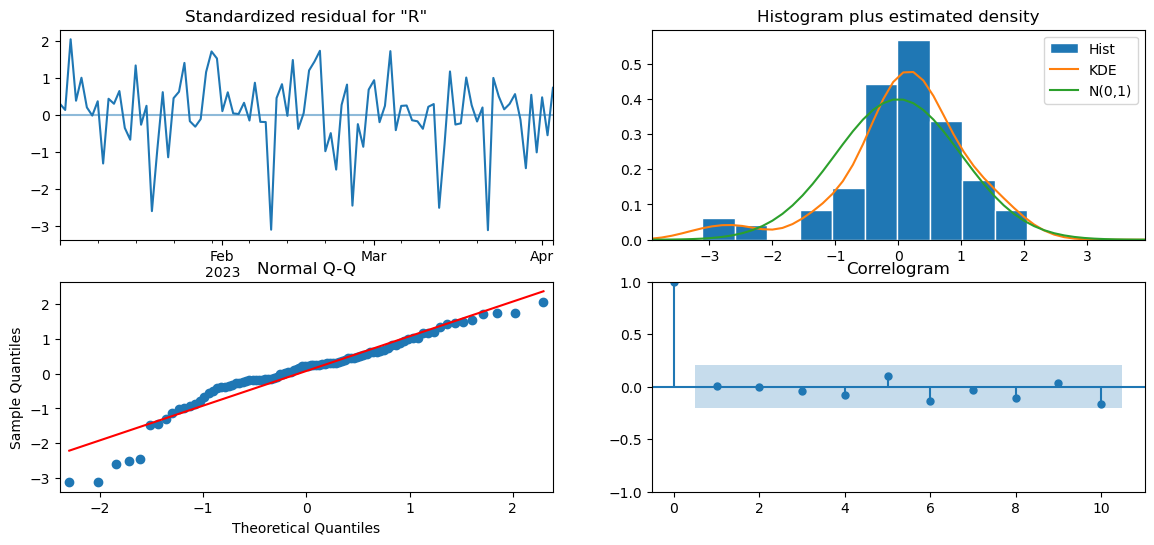

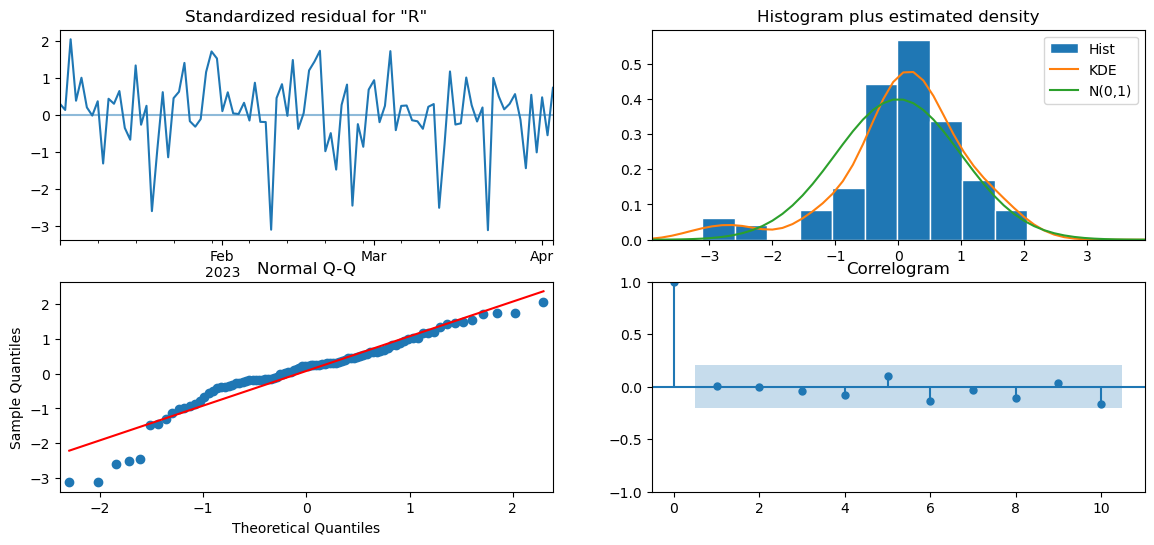

In [40]:
arimax_results.plot_diagnostics(figsize=(14, 6))

In [42]:
#Auto ARIMA with StatsForecast

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y = filtered_sales['Revenue']
y.index = pd.to_datetime(y.index)

y_train, y_test = temporal_train_test_split(y, test_size=7)
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = StatsForecastAutoARIMA(sp=7)  # Set sp=7 for weekly seasonality
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=fh)

ModuleNotFoundError: StatsForecastAutoARIMA requires package 'statsforecast>=1.0.0' to be present in the python environment, with version >=1.0.0, but incompatible version 0.7.0 was found. This version requirement is not one by sktime, but specific to the module, class or object with name StatsForecastAutoARIMA(sp=7).